In [1]:
# import library

import os
from shutil import copy
import xml.etree.ElementTree as ET
import xml
from xml.dom import minidom
import cv2

In [2]:
datapath = '../../dataset/Annotations'
xmllspath = '../../dataset/tasklist/t1_train.txt'
imagepath = '../../dataset/JPEGImages'
savedir = '../../dataset/BackgroundCrop_Train'
IOUthreshold = 0.05

VOC_CLASS_NAMES = [
    "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat",
    "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person",
    "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]
VOC_CLASS_NAMES_COCOFIED = [
    "airplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat",
    "chair", "cow", "dining table", "dog", "horse", "motorcycle", "person",
    "potted plant", "sheep", "couch", "train", "tv"
]

VOCclass = set(VOC_CLASS_NAMES).union(set(VOC_CLASS_NAMES_COCOFIED))


In [3]:
with open(xmllspath, newline='') as f:
    data = f.read()


xmlls = data.split("\n")

while '' in xmlls:
    xmlls.remove('')

xmlls = [data+'.xml' for data in xmlls]

In [12]:
# Crop InDistribution, NearDistribution

count = 0
for idx, singleXml in enumerate(xmlls):
    
    xmlname = os.path.join(datapath,singleXml)
    doc = ET.parse(xmlname)
    root = doc.getroot()
    imagename = root.find('filename').text
    filepath = os.path.join('../../dataset/JPEGImages',imagename)
    objects = root.iter('object')

    for annotation in objects:
        name = annotation.find('name').text
        
        if name in VOCclass:
            # change name to COCO categories
            if name in VOC_CLASS_NAMES:
                id = VOC_CLASS_NAMES.index(name)
                name = VOC_CLASS_NAMES_COCOFIED[id]
            
            # get bbox
            bndbox = annotation.find('bndbox')
            
            x_l = int(bndbox.find('ymin').text)
            y_b = int(bndbox.find('xmin').text)
            x_r = int(bndbox.find('ymax').text)
            y_u = int(bndbox.find('xmax').text)

            src = cv2.imread(filepath)
            crop = src[x_l:x_r,y_b:y_u,:]

            y = y_u-y_b
            x = x_r-x_l
            length = max(x, y)

            top = int(length/2 - x/2)
            bottom = int(length/2 - x/2)
            left = int(length/2 - y/2)
            right = int(length/2 - y/2)

            borderType = cv2.BORDER_CONSTANT
            crop = cv2.copyMakeBorder(crop, top, bottom, left, right, borderType)
            crop = cv2.resize(crop,(256,256))

            # if no dir make one
            savepath = os.path.join(savedir,name)
            if not(os.path.exists(savepath)):
                os.makedirs(savepath)
            
            imgname = name + "_" + imagename
            cropimagepath = os.path.join(savepath,imgname)

            
            # save to dir
            cv2.imwrite(cropimagepath,crop)

            #count
            count = count + 1

count

KeyboardInterrupt: 

In [35]:
windowsize = [
    [64,32], [64,64], [64,128],
    [128,64],[128,128],[128,256], [128,64],[128,128],[128,256], [128,64],[128,128],[128,256],
    [256,128],[256,256],[256,512], [256,128],[256,256],[256,512], [256,128],[256,256],[256,512], [256,128],[256,256],[256,512], [256,128],[256,256],[256,512]
    ]
import random


In [36]:
def calculateIOU(gtbox,cropbox):
    IOUs = []
    for box in gtbox:
        Inter_x_l = max(box[0],cropbox[0])
        Inter_x_r = min(box[1],cropbox[1])
        Inter_y_b = max(box[2],cropbox[2])
        Inter_y_u = min(box[3],cropbox[3])

        width = max(Inter_x_r-Inter_x_l,0)
        length = max(Inter_y_u-Inter_y_b,0)

        InterArea = width*length

        Area1 = (box[1]-box[0]) * (box[3]-box[2])
        Area2 = (cropbox[1]-cropbox[0]) * (cropbox[3]-cropbox[2])

        Union = Area1+Area2-InterArea
        IOU = InterArea/Union
        IOUs.append(IOU)

    IOU = max(IOUs)
    return IOU

In [27]:
# Crop FarDistribution
random.seed(1)

count = 0
for idx, singleXml in enumerate(xmlls):
    
    xmlname = os.path.join(datapath,singleXml)
    doc = ET.parse(xmlname)
    root = doc.getroot()
    imagename = root.find('filename').text
    filepath = os.path.join('../../dataset/JPEGImages',imagename)
    objects = root.iter('object')
    src = cv2.imread(filepath)
    max_x = src.shape[0]
    max_y = src.shape[1]

    gtbox = []
    for annotation in objects:
        # get bbox
        bndbox = annotation.find('bndbox')
        
        x_l = int(bndbox.find('ymin').text)
        y_b = int(bndbox.find('xmin').text)
        x_r = int(bndbox.find('ymax').text)
        y_u = int(bndbox.find('xmax').text)

        gtbox.append([x_l,x_r,y_b,y_u])
    
    num = 0
    while num<100:
        
        window = random.choice(windowsize)
        x_l = random.randint(0,max_x)
        y_b = random.randint(0,max_y)
        x_r = x_l + window[0]
        y_u = y_b + window[1]
        
        
        
        crop = src[x_l:x_r,y_b:y_u,:]
        y = y_u-y_b
        x = x_r-x_l
        length = max(x, y)

        top = int(length/2 - x/2)
        bottom = int(length/2 - x/2)
        left = int(length/2 - y/2)
        right = int(length/2 - y/2)

        borderType = cv2.BORDER_CONSTANT
        try:
            assert x_r <= src.shape[0] and y_u <= src.shape[1]
            crop = cv2.copyMakeBorder(crop, top, bottom, left, right, borderType)
            crop = cv2.resize(crop,(256,256))

        # continue for invalid cropping (e.g. cropping outside of source image)
        except Exception:
            continue

        # if bigger than IOU break
        cropbox = [x_l,x_r,y_b,y_u]
        IOU = calculateIOU(gtbox,cropbox)
        if IOU<IOUthreshold:
            break
        num = num+1
    
    
    # if no dir make one
    if not(os.path.exists(savedir)):
        os.makedirs(savedir)

    imgname = 'BackgroundCropTrain_'+ str(count)+'.jpg'
    cropimagepath = os.path.join(savedir,imgname)

    
    # save to dir
    cv2.imwrite(cropimagepath,crop)

    #count
    count = count + 1
    print(count)

count

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


16551

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0.010700296168911818


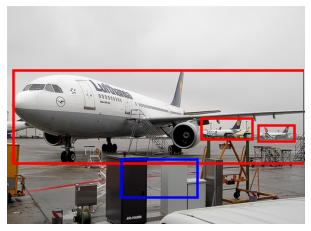

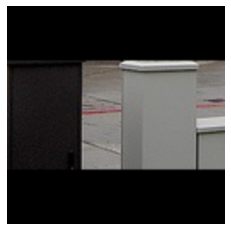

In [48]:
# Plot FarDistribution
random.seed(1)
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

count = 0
for idx, singleXml in enumerate(xmlls):
    
    xmlname = os.path.join(datapath,singleXml)
    doc = ET.parse(xmlname)
    root = doc.getroot()
    imagename = root.find('filename').text
    filepath = os.path.join('../../dataset/JPEGImages',imagename)
    objects = root.iter('object')
    src = cv2.imread(filepath)
    max_x = src.shape[0]
    max_y = src.shape[1]

    gtbox = []
    for annotation in objects:
        # get bbox
        bndbox = annotation.find('bndbox')
        
        x_l = int(bndbox.find('ymin').text)
        y_b = int(bndbox.find('xmin').text)
        x_r = int(bndbox.find('ymax').text)
        y_u = int(bndbox.find('xmax').text)

        gtbox.append([x_l,x_r,y_b,y_u])
    
    num = 0
    while num<100:
        
        window = random.choice(windowsize)
        x_l = random.randint(0,max_x)
        y_b = random.randint(0,max_y)
        x_r = x_l + window[0]
        y_u = y_b + window[1]
        
        crop = src[x_l:x_r,y_b:y_u,:]
        y = y_u-y_b
        x = x_r-x_l
        length = max(x, y)

        top = int(length/2 - x/2)
        bottom = int(length/2 - x/2)
        left = int(length/2 - y/2)
        right = int(length/2 - y/2)

        borderType = cv2.BORDER_CONSTANT
        try:
            assert x_r <= src.shape[0] and y_u <= src.shape[1]
            crop = cv2.copyMakeBorder(crop, top, bottom, left, right, borderType)
            crop = cv2.resize(crop,(256,256))

        # continue for invalid cropping (e.g. cropping outside of source image)
        except Exception:
            continue

        # if bigger than IOU break
        cropbox = [x_l,x_r,y_b,y_u]
        IOU = calculateIOU(gtbox,cropbox)
        if IOU<IOUthreshold:
            break
        num = num+1
    
    print(idx)
    if idx==14:
        print(IOU)
        # Plot Cropped Images
        fig1, ax1 = plt.subplots(1)
        ax1.imshow(cv2.cvtColor(src, cv2.COLOR_BGR2RGB))
        ax1.axis('off')
        for box in gtbox:
            patch = patches.Rectangle((box[2], box[0]),
                    box[3]-box[2],
                    box[1]-box[0],
                    edgecolor = 'red',
                    facecolor = None,
                    fill=False,
                    lw = 2.5
                )
            ax1.add_patch(patch)
        
        patch = patches.Rectangle((cropbox[2], cropbox[0]),
                cropbox[3]-cropbox[2],
                cropbox[1]-cropbox[0],
                edgecolor = 'blue',
                facecolor = None,
                lw = 2.5,
                fill=False
            )
        ax1.add_patch(patch)

        fig2, ax2 = plt.subplots(1)
        ax2.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
        ax2.axis('off')
        
        break

In [39]:
gtbox,cropbox

([[50, 330, 141, 500]], [157, 221, 360, 424])

In [41]:
for idx,box in enumerate(gtbox):
    Inter_x_l = max(box[0],cropbox[0])
    Inter_x_r = min(box[1],cropbox[1])
    Inter_y_b = max(box[2],cropbox[2])
    Inter_y_u = min(box[3],cropbox[3])

    width = max(Inter_x_r-Inter_x_l,0)
    length = max(Inter_y_u-Inter_y_b,0)

    InterArea = width*length

    Area1 = (box[1]-box[0]) * (box[3]-box[2])
    Area2 = (cropbox[1]-cropbox[0]) * (cropbox[3]-cropbox[2])

    Union = Area1+Area2-InterArea
    IOU = InterArea/Union

    
    if idx == 0:
        break

print('Inter coordinate:',(Inter_x_l,Inter_x_r,Inter_y_b,Inter_y_u))
print('InterArea',InterArea)
print('Union',Union)
print('Area1',Area1)
print('Area2',Area2)

Inter coordinate: (157, 221, 360, 424)
InterArea 4096
Union 100520
Area1 100520
Area2 4096


In [18]:
xmlstr = minidom.parseString(ET.tostring(root)).toprettyxml(indent="   ")
print(xmlstr)

<?xml version="1.0" ?>
<annotation>
   
	
   <folder>VOC2007</folder>
   
	
   <filename>000001.jpg</filename>
   
	
   <source>
      
		
      <database>The VOC2007 Database</database>
      
		
      <annotation>PASCAL VOC2007</annotation>
      
		
      <image>flickr</image>
      
		
      <flickrid>341012865</flickrid>
      
	
   </source>
   
	
   <owner>
      
		
      <flickrid>Fried Camels</flickrid>
      
		
      <name>Jinky the Fruit Bat</name>
      
	
   </owner>
   
	
   <size>
      
		
      <width>353</width>
      
		
      <height>500</height>
      
		
      <depth>3</depth>
      
	
   </size>
   
	
   <segmented>0</segmented>
   
	
   <object>
      
		
      <name>dog</name>
      
		
      <pose>Left</pose>
      
		
      <truncated>1</truncated>
      
		
      <difficult>0</difficult>
      
		
      <bndbox>
         
			
         <xmin>48</xmin>
         
			
         <ymin>240</ymin>
         
			
         <xmax>195</xmax>
         
			
         <yma